##### This notebook was developed and tested with Python 3.10.12 on a Linux system

##### `# type: ignore` comments are to suppress incorrect warnings in VSCode

### Installing requirements (other package versions may produce different results)

In [1]:
%pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


### Begin imports

In [2]:
import os
import shutil
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold

### Disabling GPU usage

This was needed on my machine due to a CUDA error with my GPU

It needs to be done before importing tensorflow packages

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = ""

### Rest of imports

In [4]:
from tensorflow.keras.utils import to_categorical # type: ignore
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Dense # type: ignore
from tensorflow.keras.callbacks import EarlyStopping # type: ignore
from tensorflow import keras # type: ignore
import tensorflowjs as tfjs
import keras_tuner as kt

2024-04-21 21:54:35.937986: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-21 21:54:35.938012: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-21 21:54:35.938934: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-21 21:54:35.945028: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-21 21:54:36.947694: W tensorflow/compiler/tf2

### Data Preprocessing

Load the [721 Weight Training Workouts](https://www.kaggle.com/datasets/joep89/weightlifting/data) dataset from Kaggle (downloaded manually), remove unneeded columns, and convert lbs to kg and date to datetime

As the data will be sorted by date and undergo a temporal split, additional details extracted from 'Data' won't have an impact on the outcome of the model traininig, therefore they were left out of the final version of the notebook.

Conversion value source: [Convert kg to lbs](https://www.unitconverters.net/weight-and-mass/kg-to-lbs.htm)

In [5]:
data = pd.read_csv('./weightlifting_721_workouts.csv')

columns_to_remove = ['Distance', 'Seconds', 'Notes', 'Workout Notes']
data.drop(columns=columns_to_remove, inplace=True)

CONVERSION_VAL = 2.2046226218
data['Weight'] = data['Weight'] / CONVERSION_VAL

data['Date'] = pd.to_datetime(data['Date'])
# data['Weekday'] = data['Date'].dt.weekday
# data['Year'] = data['Date'].dt.year
# data['Month'] = data['Date'].dt.month
# data['Time'] = data['Date'].dt.time

data.head()

,Date,Workout Name,Exercise Name,Set Order,Weight,Reps
0,2015-10-23 17:06:37,Chest,Incline Bench Press (Barbell),1,61.234970,8
1,2015-10-23 17:06:37,Chest,Incline Bench Press (Barbell),2,61.234970,8
2,2015-10-23 17:06:37,Chest,Incline Bench Press (Barbell),3,61.234970,5
3,2015-10-23 17:06:37,Chest,Incline Bench Press (Barbell),4,83.914588,7
4,2015-10-23 17:06:37,Chest,Incline Bench Press (Barbell),5,104.326245,8


### Feature Engineering

Sort data to prepare for temporal split, then drop the 'Date' column since it's no longer needed

Create new features based on historical data:
- Calculate percentage changes
- Calculate moving averages for weight and reps over the last 5 sessions
	- Sources:
		- [Moving averages](https://d1wqtxts1xzle7.cloudfront.net/30734999/10.1.1.155.4196-libre.pdf?1392078835=&response-content-disposition=inline%3B+filename%3DMoving_averages.pdf&Expires=1713709781&Signature=P1iLNzZkGpRsbXaLwZfH2FbmhYIFZ0dbiL0xUkj-u7zdi5FszW45zmGjdIxqQphtViUv4KxQ5S-nanVbHpTRKgpmDpYQk~k-5plvDPD1mZrPkR1NSOX4tsNjOfVceSBp7X2vBnoNhhcISSYfJ8oNpXHgh~SidBZDbDCpWq5AYy9UXa12kmXPqDlyNFvQShppD1oQI4R57zJjTXWhU0ljw7B90m2Yk64lWXZDnlJhUg9Drug5yfhP~7z-zVZXie19om0UbjpDOk11d0-fpk9BUIHdEpaaMU8a47~gSTARqrCY5L2TYtVNNjO0FmlUOQ1ENh0ITyBhnSQ3fHleKLk90Q__&Key-Pair-Id=APKAJLOHF5GGSLRBV4ZA)
		- [How to Calculate a Rolling Average (Mean) in Pandas](https://datagy.io/rolling-average-pandas/)

Handle missing values

In [6]:
data.sort_values(by=['Exercise Name', 'Date'], inplace=True)
data = data.drop(['Date'], axis=1)

data['Weight Change %'] = data.groupby('Exercise Name')['Weight'].pct_change() * 100
data['Reps Change %'] = data.groupby('Exercise Name')['Reps'].pct_change() * 100

data['Weight Moving Average'] = data.groupby('Exercise Name')['Weight'].transform(lambda x: x.rolling(window=5, min_periods=1).mean())
data['Reps Moving Average'] = data.groupby('Exercise Name')['Reps'].transform(lambda x: x.rolling(window=5, min_periods=1).mean())

data.fillna(0, inplace=True)

print("Data Preview After Feature Engineering:")
data.head()

Data Preview After Feature Engineering:


,Workout Name,Exercise Name,Set Order,Weight,Reps,Weight Change %,Reps Change %,Weight Moving Average,Reps Moving Average
3247,Chest,Bench Press (Barbell),1,61.234970,8,0.000000,0.0,61.234970,8.00
3248,Chest,Bench Press (Barbell),2,70.306817,5,14.814815,-37.5,65.770894,6.50
3249,Chest,Bench Press (Barbell),3,83.914588,5,19.354839,0.0,71.818792,6.00
3250,Chest,Bench Press (Barbell),4,83.914588,5,0.000000,0.0,74.842741,5.75
4855,Shoulder Day,Bench Press (Barbell),1,61.234970,6,-27.027027,20.0,72.121187,5.80


### Removing outlier data using Interquartile Range method

Values outside 1.5 * IQR from the first and third quartiles are considered outliers

Sources:
- [A Review of Statistical Outlier Methods](https://www.statisticaloutsourcingservices.com/Outlier2.pdf)
- [Pandas IQR: Calculate the Interquartile Range in Python](https://datagy.io/pandas-iqr/)

In [7]:
Q1 = data['Weight'].quantile(0.25)
Q3 = data['Weight'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
data = data[(data['Weight'] >= lower_bound) & (data['Weight'] <= upper_bound)]

### Label Creation

Instead of identifying if weight or reps have increased, the created labels are suggestions about whether to increase weight or reps based on the historical data

Identify if moving average of weight or reps are very high (e.g. intermediate or advanced lifter), in which case the minimum threshold is lowered

In [8]:
MIN_WEIGHT_CHANGE_PERCENT = 5
MIN_REPS_CHANGE_PERCENT = 20

def label_suggestions(row):
    if row['Weight Moving Average'] > 100: # averate weight lifted is high
        adjusted_weight_change_percent = MIN_WEIGHT_CHANGE_PERCENT * 0.8
    else:
        adjusted_weight_change_percent = MIN_WEIGHT_CHANGE_PERCENT

    if row['Reps Moving Average'] > 15: # average reps performed is high
        adjusted_reps_change_percent = MIN_REPS_CHANGE_PERCENT * 0.8
    else:
        adjusted_reps_change_percent = MIN_REPS_CHANGE_PERCENT

	# weight has increased and reps haven't
    if row['Weight Change %'] > adjusted_weight_change_percent and row['Reps Change %'] < 5:
        return 'increase reps'
    # reps have increased
    elif row['Reps Change %'] > adjusted_reps_change_percent:
        return 'increase weight, decrease reps'
    # neither weight nor reps have increased
    else:
        return 'increase weight'

data['Suggestion'] = data.apply(label_suggestions, axis=1)

print("Data Preview with Labels:")
data[['Exercise Name', 'Weight', 'Reps', 'Weight Change %', 'Reps Change %', 'Suggestion']].head()

Data Preview with Labels:


,Exercise Name,Weight,Reps,Weight Change %,Reps Change %,Suggestion
3247,Bench Press (Barbell),61.234970,8,0.000000,0.0,increase weight
3248,Bench Press (Barbell),70.306817,5,14.814815,-37.5,increase reps
3249,Bench Press (Barbell),83.914588,5,19.354839,0.0,increase reps
3250,Bench Press (Barbell),83.914588,5,0.000000,0.0,increase weight
4855,Bench Press (Barbell),61.234970,6,-27.027027,20.0,increase weight


### More Data Preprocessing

Convert infinite values to NaN, then replace NaNs with 0

One-hot encode the labels for compatibility with the model

Select features and labels for the model

In [9]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.fillna(0, inplace=True)

label_encoder = LabelEncoder()
data['Suggestion'] = label_encoder.fit_transform(data['Suggestion'])

X = data[['Weight Change %', 'Reps Change %', 'Weight Moving Average', 'Reps Moving Average']].values
y = to_categorical(data['Suggestion'])

/home/dominik/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/dominik/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


### Global training values multiplier

Multiplies various training values, used for testing purposes

Ratio of default values recommended by the official [keras tuner documentation](https://www.tensorflow.org/tutorials/keras/keras_tuner)

Can't be float because end values need to be integers

Default values:
- `patience=5` (early stopping)
- `epochs=50` (training)
- `max_epochs=10` (hyper tuner)

In [10]:
TRAINING_VALUES_MULTIPLIER = 2

### K-Fold Cross Validation

Initialising a base model for evaluation, to gain insights on its performance

Three fully connected layers:
- input layer with relu activation
- hidden layer with relu activation
- output layer with softmax activation

Also adding early stopping, which will also be used later

Sources:
- [Reliable Accuracy Estimates from k-Fold Cross Validation](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8698831&casa_token=3Xko69OHe2oAAAAA:C0Aqkati7NR6wfbDnEmSedYyA76yE2sS_l9rAcacyzgRPIk_DmPWAzFASGBtLfLbSJUExqSVKA&tag=1)
- [Stratified K Fold Cross Validation](https://www.geeksforgeeks.org/stratified-k-fold-cross-validation/)
- [Building Sequential Models with Keras: A Comprehensive Guide for Deep Learning](https://deeplearningmy.com/building-sequential-models-with-keras-a-comprehensive-guide-for-deep-learning/)

In [11]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5 * TRAINING_VALUES_MULTIPLIER,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

y_labels = np.argmax(y, axis=1)

NUM_FOLDS = 5 # number of splits
kfold = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)

# storing the model's performance for each fold
fold_no = 1
acc_per_fold = []
loss_per_fold = []

for train, test in kfold.split(X, y_labels):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(X[train].shape[1],)),
        Dense(64, activation='relu'),
        Dense(y.shape[1], activation='softmax')
    ])
    model.compile(
        optimizer='adam',
		loss='categorical_crossentropy',
		metrics=['accuracy']
  	)
    history = model.fit(
        X[train],
        y[train],
		epochs=50 * TRAINING_VALUES_MULTIPLIER,
		validation_data=(X[test], y[test]),
		callbacks=[early_stopping],
    )
    # get generalisation metrics
    scores = model.evaluate(X[test], y[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    
    fold_no += 1 # increase fold number

2024-04-21 21:54:38.693708: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-04-21 21:54:38.693750: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: mint
2024-04-21 21:54:38.693758: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: mint
2024-04-21 21:54:38.693898: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 535.171.4
2024-04-21 21:54:38.693922: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 535.161.7
2024-04-21 21:54:38.693928: E external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:244] kernel version 535.161.7 does not match DSO version 535.171.4 -- cannot find working devices in this configuration


Epoch 1/100
244/244 [==============================] - 1s 2ms/step - loss: 0.3667 - accuracy: 0.9001 - val_loss: 0.1741 - val_accuracy: 0.9528
Epoch 2/100
244/244 [==============================] - 0s 2ms/step - loss: 0.1539 - accuracy: 0.9456 - val_loss: 0.2675 - val_accuracy: 0.9097
Epoch 3/100
244/244 [==============================] - 0s 2ms/step - loss: 0.1391 - accuracy: 0.9464 - val_loss: 0.1725 - val_accuracy: 0.9497
Epoch 4/100
244/244 [==============================] - 0s 2ms/step - loss: 0.1519 - accuracy: 0.9450 - val_loss: 0.1797 - val_accuracy: 0.9446
Epoch 5/100
244/244 [==============================] - 0s 1ms/step - loss: 0.1332 - accuracy: 0.9491 - val_loss: 0.1704 - val_accuracy: 0.9369
Epoch 6/100
244/244 [==============================] - 0s 1ms/step - loss: 0.1333 - accuracy: 0.9493 - val_loss: 0.1561 - val_accuracy: 0.9456
Epoch 7/100
244/244 [==============================] - 0s 1ms/step - loss: 0.1378 - accuracy: 0.9488 - val_loss: 0.2023 - val_accuracy: 0.9472

### Results of K-Fold Cross Validation

Prints the average score and loss for each fold

Since results are good, the same structure can be used for the subsequent models

In [12]:
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.10747776180505753 - Accuracy: 96.97436094284058%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.11345861107110977 - Accuracy: 95.53617238998413%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.07876528054475784 - Accuracy: 97.12673425674438%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.06591363251209259 - Accuracy: 97.69112467765808%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.07143478095531464 - Accuracy: 97.28065729141235%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 96.9218099117279 (+- 0.7328524531855322)
> Loss: 0.08741001337766648
-----------------------

### Temporal data split + Normalisation

Data has already been sorted by date, therefore we can simply split the data into training, validation, and testing sets

60% for training, 20% for validation, 20% for testing

After the split, the data is scaled to be in the same range

In [13]:
train_size = int(len(data) * 0.6)
validation_size = int(len(data) * 0.2)
test_size = len(data) - train_size - validation_size
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + validation_size], y[train_size:train_size + validation_size]
X_test, y_test = X[train_size + validation_size:], y[train_size + validation_size:]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

### Model Building with Keras Tuner

This section follows the steps detailed by the [keras tuner documentation](https://www.tensorflow.org/tutorials/keras/keras_tuner)

Using the same structure as the previous model

In [14]:
def build_model(hp):
    model = Sequential([
        Dense(
            units=hp.Int('units_1', min_value=32, max_value=512, step=32),
            input_shape=(X_train.shape[1],),
            activation='relu'
        ),
        Dense(
            units=hp.Int('units_2', min_value=32, max_value=256, step=32),
            activation='relu'
        ),
        Dense(y_train.shape[1], activation='softmax')
    ])
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# remove any previous directories
keras_tuning_dir = './'
keras_tuning_name = 'keras_tuning'
if os.path.exists(keras_tuning_dir + keras_tuning_name):
	shutil.rmtree(keras_tuning_dir + keras_tuning_name)

tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10 * TRAINING_VALUES_MULTIPLIER,
    factor=3,
    directory=keras_tuning_dir,
    project_name=keras_tuning_name
)

### Executing hyperparameter search

Continuing the the [keras tuner documentation](https://www.tensorflow.org/tutorials/keras/keras_tuner) steps

After the search, we get the best hyperparameters

In [15]:
tuner.search(
    X_train,
    y_train,
    epochs=50 * TRAINING_VALUES_MULTIPLIER,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The best number of units in the first dense layer is {best_hps.get('units_1')} and in the second dense layer is {best_hps.get('units_2')}
The best learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")

Trial 30 Complete [00h 00m 10s]
val_accuracy: 0.9933299422264099

Best val_accuracy So Far: 0.9933299422264099
Total elapsed time: 00h 01m 55s

The best number of units in the first dense layer is 512 and in the second dense layer is 96
The best learning rate for the optimizer is 0.001.



### Building a new model with the best hyperparameters

In [16]:
model = tuner.hypermodel.build(best_hps) # type: ignore

history = model.fit(
    X_train,
    y_train,
    epochs=50 * TRAINING_VALUES_MULTIPLIER,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/100
183/183 [==============================] - 1s 2ms/step - loss: 0.3465 - accuracy: 0.8728 - val_loss: 0.1758 - val_accuracy: 0.9338
Epoch 2/100
183/183 [==============================] - 0s 3ms/step - loss: 0.1652 - accuracy: 0.9436 - val_loss: 0.1026 - val_accuracy: 0.9543
Epoch 3/100
183/183 [==============================] - 0s 2ms/step - loss: 0.1284 - accuracy: 0.9588 - val_loss: 0.0665 - val_accuracy: 0.9759
Epoch 4/100
183/183 [==============================] - 0s 2ms/step - loss: 0.1126 - accuracy: 0.9656 - val_loss: 0.0489 - val_accuracy: 0.9820
Epoch 5/100
183/183 [==============================] - 0s 2ms/step - loss: 0.0978 - accuracy: 0.9658 - val_loss: 0.0462 - val_accuracy: 0.9820
Epoch 6/100
183/183 [==============================] - 0s 2ms/step - loss: 0.0924 - accuracy: 0.9677 - val_loss: 0.0328 - val_accuracy: 0.9877
Epoch 7/100
183/183 [==============================] - 0s 2ms/step - loss: 0.0897 - accuracy: 0.9684 - val_loss: 0.0328 - val_accuracy: 0.9913

### Building the final model with the best number of epochs

In [17]:
hypermodel = tuner.hypermodel.build(best_hps) # type: ignore

history = hypermodel.fit(
	X_train,
	y_train,
	epochs=best_epoch,
	batch_size=32,
	validation_data=(X_val, y_val)
)

Epoch 1/19
183/183 [==============================] - 1s 3ms/step - loss: 0.3516 - accuracy: 0.8714 - val_loss: 0.1965 - val_accuracy: 0.9277
Epoch 2/19
183/183 [==============================] - 0s 2ms/step - loss: 0.1730 - accuracy: 0.9384 - val_loss: 0.1354 - val_accuracy: 0.9482
Epoch 3/19
183/183 [==============================] - 0s 2ms/step - loss: 0.1286 - accuracy: 0.9576 - val_loss: 0.0676 - val_accuracy: 0.9846
Epoch 4/19
183/183 [==============================] - 0s 2ms/step - loss: 0.1023 - accuracy: 0.9663 - val_loss: 0.0435 - val_accuracy: 0.9851
Epoch 5/19
183/183 [==============================] - 0s 2ms/step - loss: 0.1048 - accuracy: 0.9649 - val_loss: 0.0381 - val_accuracy: 0.9867
Epoch 6/19
183/183 [==============================] - 0s 2ms/step - loss: 0.0868 - accuracy: 0.9701 - val_loss: 0.0338 - val_accuracy: 0.9903
Epoch 7/19
183/183 [==============================] - 0s 2ms/step - loss: 0.0834 - accuracy: 0.9699 - val_loss: 0.0282 - val_accuracy: 0.9882
Epoch 

### Plotting accuracy and loss change over epochs

Note: this code is reused from my own Applied AI coursework

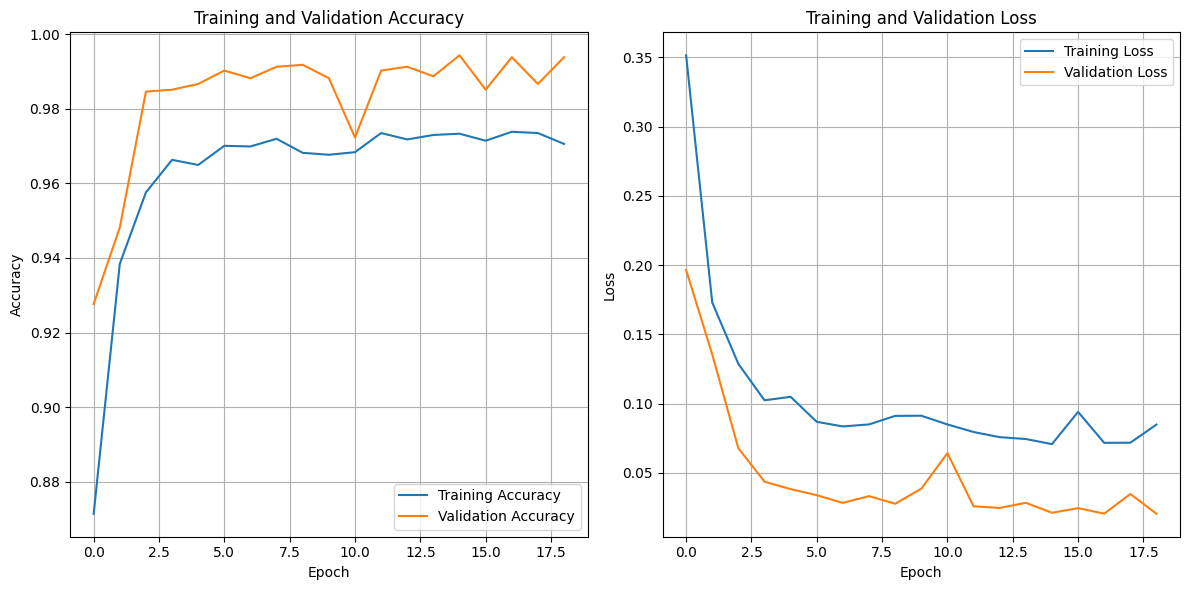

In [18]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Evaluating the model on the test set

In [19]:
test_loss, test_accuracy = hypermodel.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

61/61 [==============================] - 0s 1ms/step - loss: 0.1655 - accuracy: 0.9610
Test Loss: 0.16552893817424774, Test Accuracy: 0.9610256552696228


### Generating predictions for the test set

In [20]:
predictions = hypermodel.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

actual_classes = np.argmax(y_test, axis=1)

accuracy = accuracy_score(actual_classes, predicted_classes)
precision = precision_score(actual_classes, predicted_classes, average='macro')
recall = recall_score(actual_classes, predicted_classes, average='macro')
f1 = f1_score(actual_classes, predicted_classes, average='macro')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

61/61 [==============================] - 0s 1ms/step
Accuracy: 0.96
Precision: 0.98
Recall: 0.95
F1 Score: 0.96


### Calculating and plotting the confusion matrix

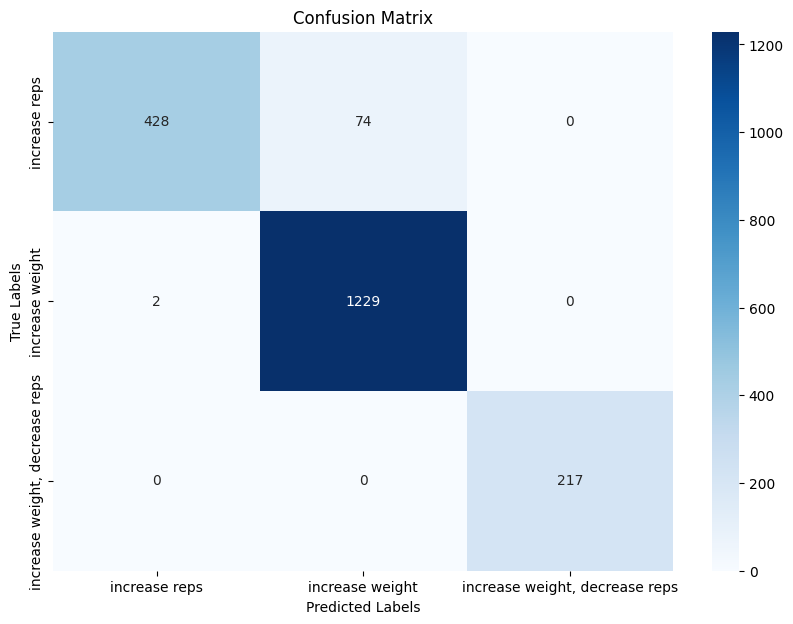

In [21]:
conf_matrix = confusion_matrix(actual_classes, predicted_classes)

plt.figure(figsize=(10, 7))
sns.heatmap(
    conf_matrix,
    annot=True, fmt='g',
    cmap='Blues',
    xticklabels=label_encoder.classes_, # type: ignore
    yticklabels=label_encoder.classes_ # type: ignore
)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### Additional classification report

Calculates precision, recall, f1 score, and support for each class

In [22]:
print("Detailed Classification Report:")
print(classification_report(actual_classes, predicted_classes))

Detailed Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.85      0.92       502
           1       0.94      1.00      0.97      1231
           2       1.00      1.00      1.00       217

    accuracy                           0.96      1950
   macro avg       0.98      0.95      0.96      1950
weighted avg       0.96      0.96      0.96      1950



We can see that almost all values are close to 100%, indicating that the model is performing well.

Despite employing methods like K-Fold Cross Validation and Hyperparameter tuning, the recall value of the 'increase reps' class seems to be slightly lower. For future maintenance: it should ideally be increased to the same level as the the rest of the classes. Regardless of this one metric, the model is still performing well.

### Saving the model in Keras format, then convert it to TensorFlow.js format

Source: [Importing a Keras model into TensorFlow.js](https://www.tensorflow.org/js/tutorials/conversion/import_keras)

In [23]:
model_path = './exertrack_model.keras'
tfjs_target_path = './exertrack_model_tfjs'

# remove any previous files/directories
if os.path.exists(model_path):
    os.remove(model_path)
if os.path.exists(tfjs_target_path):
    shutil.rmtree(tfjs_target_path)

hypermodel.save(model_path)

tfjs.converters.save_keras_model(hypermodel, tfjs_target_path)

/home/dominik/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
